In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from xgboost import XGBRegressor
import xgboost as xgb
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import math
from sklearn.metrics import f1_score

In [54]:
#Info : 552 subjects, 21 waves, 8378 rows
df = pd.read_csv('Speed_Dating_Data.csv', encoding = "ISO-8859-1")
#df = pd.read_csv('SpeedDatingData.csv')

In [6]:
#df.isnull().sum()

In [7]:
#df.head()
#there were 690 matches only out of a potential 4189 matches
matches = pd.crosstab(df['match'], columns = "count")
print(matches)


col_0  count
match       
0       6998
1       1380


In [225]:
data2 = pd.concat([df.iloc[:,0], #ID
                  df.iloc[:,2], #gender
                  df.iloc[:,5],
                  df.iloc[:,9:12], #order of date
                  #df.iloc[:, 11:12], #partner's id
                  df.iloc[:, 12:13], #match, 
                  df.iloc[:,13:17], #int_corr, samerace, age of partner, race of partner 
                  df.iloc[:,17:23], #stated preferences
                  df.iloc[:,23:24], #decision of partner - dec-o
                  df.iloc[:,24:28], #attr_o..fun_o
                  df.iloc[:,28:32],
                  #df.iloc[:,24:32],   # rating by partner for 6 attributes, probability of matching with partner #amb-o has lots of missing values - try eliminating
                  #df.iloc[:,32:35], # met, age, field
                  df.iloc[:,39:42],#race, importance of race, importance of religion
                  #df.iloc[:,42:43], #from   (DROPPED ZIPCODE AND INCOME AS THEY HAVE TOO MANY MISSING VALUES)
                  df.iloc[:,45:48], #goal, date, go_out
                  #df.iloc[:,48:50], #career, career_coded
                  df.iloc[:,50:67], #interests
                  #df.iloc[:,67:69], #exphappy, expnum (DROPPED - TOO MANY MISSING VALUES)
                  df.iloc[:,69:74],  #what subject looks for in the opposite sex - 6 attributes
                  df.iloc[:,74:75],  #shar1_1
                  df.iloc[:,81:87], #attr2_1,..shar2_1
                  df.iloc[:,87:92],  #attr3_1.. #91 is amb3_1 (how do you measure up)
                  df.iloc[:,97:98], #decision of subject - dec
                  df.iloc[:,98:102], #ratings by subject for partner for the 6 attributes. 101 is fun
                  df.iloc[:,102:104], #amb,shar
                  df.iloc[:,104:107]],axis=1) #like, prob, met

data3 = data2.dropna()



In [226]:
data3.head()

,iid,gender,wave,order,partner,pid,match,int_corr,samerace,age_o,...,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
0,1,0,1,4,1,11.0,0,0.14,0,27.0,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
1,1,0,1,3,2,12.0,0,0.54,0,22.0,...,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0
3,1,0,1,5,4,14.0,1,0.61,0,23.0,...,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0
4,1,0,1,7,5,15.0,1,0.21,0,24.0,...,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0
5,1,0,1,6,6,16.0,0,0.25,0,25.0,...,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0,2.0


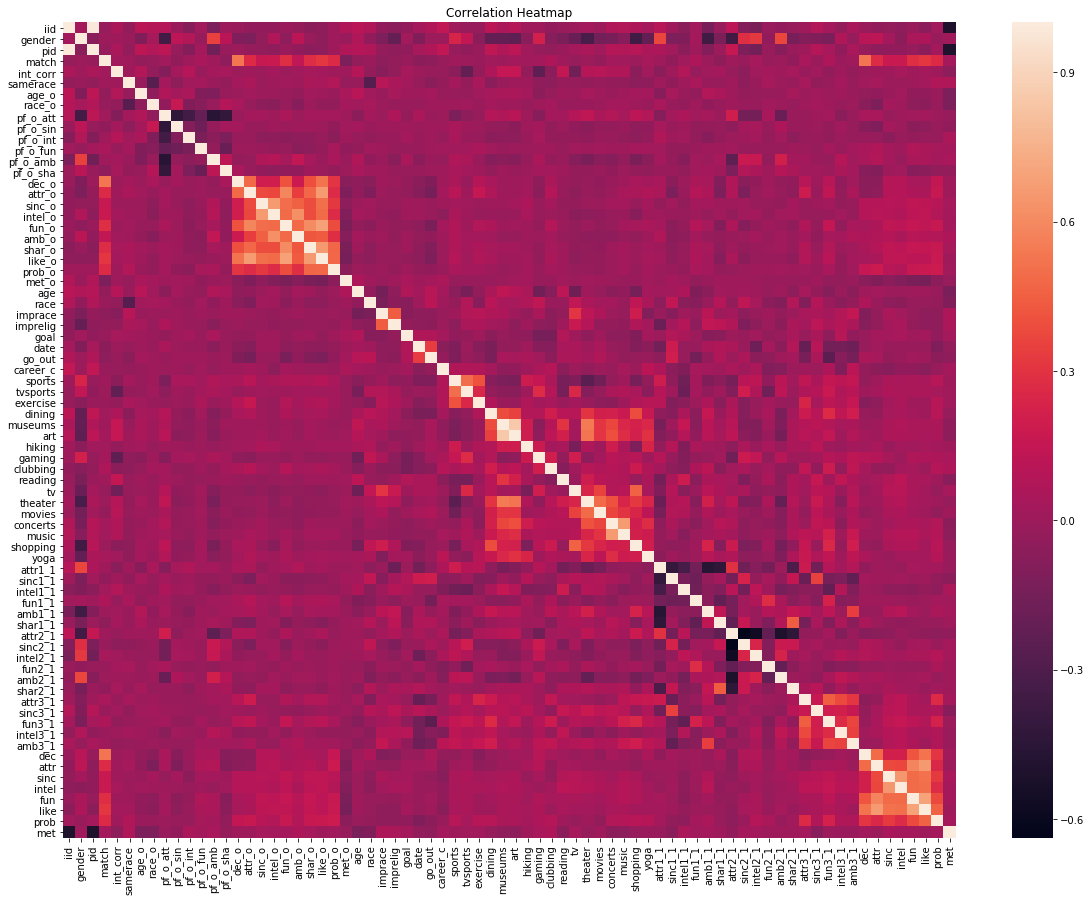

In [9]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = data.corr()
sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values)

#From the heatmap, in the match column, we see there's a high positive correlation with these features -
#dec,attr,sinc.. (ratings of partner) and dec_o, attr_o.. (ratings of subject by partner)

In [10]:
data1 = data[['dec', 'dec_o', 'attr', 'attr_o', 'sinc', 'sinc_o', 'intel', 'intel_o' ,'fun', 'fun_o','amb_o', 'like', 'like_o','prob', 'prob_o', 'match']]
corr1 = data1.corr()

print(corr1)

#sns.heatmap(corr1, xticklabels = corr1.columns.values, yticklabels = corr1.columns.values)

              dec     dec_o      attr    attr_o      sinc    sinc_o     intel  \
dec      1.000000 -0.059567  0.488982 -0.066278  0.208105  0.090666  0.207812   
dec_o   -0.059567  1.000000 -0.060715  0.487445  0.094586  0.199644  0.089816   
attr     0.488982 -0.060715  1.000000 -0.045899  0.379249  0.095346  0.371460   
attr_o  -0.066278  0.487445 -0.045899  1.000000  0.097414  0.385818  0.094254   
sinc     0.208105  0.094586  0.379249  0.097414  1.000000  0.099532  0.651428   
sinc_o   0.090666  0.199644  0.095346  0.385818  0.099532  1.000000  0.087266   
intel    0.207812  0.089816  0.371460  0.094254  0.651428  0.087266  1.000000   
intel_o  0.087382  0.203672  0.098067  0.368624  0.087614  0.661394  0.071591   
fun      0.413855  0.043248  0.581734  0.061037  0.489867  0.131349  0.488909   
fun_o    0.039250  0.408875  0.065516  0.586963  0.134933  0.499286  0.120597   
amb_o    0.063585  0.174917  0.070812  0.338273  0.096754  0.453719  0.058773   
like     0.519321  0.036998 

## OLS

In [11]:
X_reg = data[['dec','dec_o','attr','attr_o','fun','fun_o','like','like_o', 'amb_o','int_corr', 'prob', 'prob_o']]
y_reg = data.match
model = sm.OLS(y_reg, X_reg)
result_reg = model.fit()
result_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  match   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     936.5
Date:                Mon, 09 Dec 2019   Prob (F-statistic):               0.00
Time:                        19:01:51   Log-Likelihood:                -145.55
No. Observations:                6041   AIC:                             315.1
Df Residuals:                    6029   BIC:                             395.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dec            0.4463      0.008     58.397      0.000       0.431       0.461
dec_o          0.4417      0.008     57.114      0.000       0.427       0.457
attr           0.0004      0.002      0.172      0.863      -0.004       0.005
attr_o         0.0011      0.002      0.487      0.626      -0.003       0.006
fun            0.0014      0.002      0.607      0.544      -0.003       0.006
fun_o          0.0066      0.002      2.708      0.007       0.002       0.011
like          -0.0138      0.003     -4.746      0.000      -0.020      -0.008
like_o        -0.0120      0.003     -4.103      0.000      -0.018      -0.006
amb_o         -0.0123      0.002     -6.268      0.000      -0.016      -0.008
int_corr       0.0117      0.010      1.119      0.263      -0.009       0.032
prob          -0.0032      0.002     -1.815      0.070      -0.007       0.000
prob_o        -0.0016      0.002     -0.910      0.363      -0.005       0.002
==============================================================================
Omnibus:                       58.406   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              739.202
Skew:                           0.244   Prob(JB):                    3.05e-161
Kurtosis:                       1.357   Cond. No.                         61.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Classification- Kavita

gender
0    4184
1    4194
dtype: int64


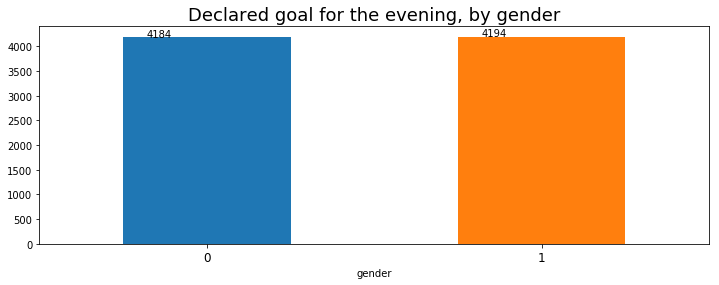

In [12]:
tmp = df[['attr', 'sinc','intel','fun','gender']].groupby(['gender']).size()
print(tmp)
ax = tmp.plot(kind='bar', figsize=(12,4))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation='horizontal')

ax.set_title('Declared goal for the evening, by gender', fontsize=18)

for i in ax.patches:
    ax.text(i.get_x()+.07, i.get_height()+3, \
            str(round((i.get_height()), 1)), fontsize=10)

In [13]:
#columns_drop=['positin1','round','iid','idg','']

In [14]:
#data.iid[df.id==10].count()

In [15]:
n=data.isna().sum()
if n.any()>0:
    print(n)
else:
    print('No null values')

No null values


In [16]:
#for col in df.columns:
#    if df[col].isna().sum()>6000:
#        columns_drop.append(col)
#df.drop(columns_drop,axis=1)

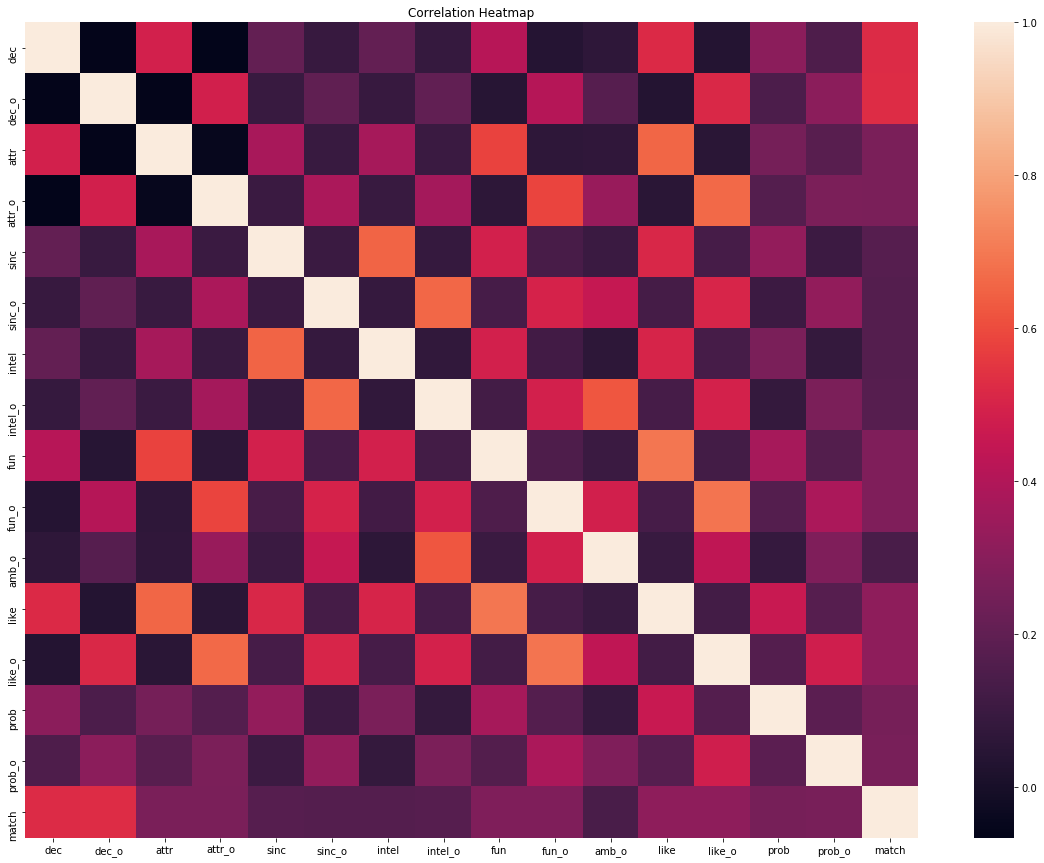

In [18]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = data1.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [60]:
attr_m=df[['iid','attr_o']].groupby(['iid']).mean()
attr_self=df[['iid','attr3_1']].groupby(['iid']).mean()
dev=attr_self['attr3_1']-attr_m['attr_o']
std_dev=dev.values.tolist()
part_dec=df[['iid','dec']].groupby(['iid']).count()
p_d=part_dec.values.tolist()

In [62]:
f=np.column_stack((p_d,dev))
d=pd.DataFrame(f,columns=['num_matches','std_dev'])


In [63]:
over_est=d[d['std_dev']>0]
ov=over_est['num_matches'].shape
print('Number of people who over-estimated their attractiveness:'+str(ov[0]))
un_est=d[d['std_dev']<0]
un=un_est['num_matches'].shape
print('Number of people who under-estimated their attractiveness:'+str(un[0]))
pr_est=d[d['std_dev']==0]
pr=pr_est['num_matches'].shape
print('Number of people who properly estimated their attractiveness:'+str(pr[0]))

Number of people who over-estimated their attractiveness:397
Number of people who under-estimated their attractiveness:137
Number of people who properly estimated their attractiveness:8


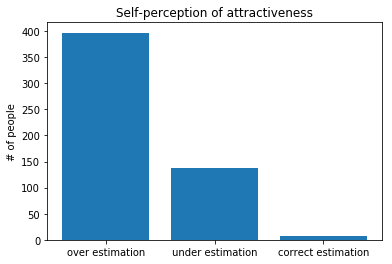

In [64]:
num=np.hstack([ov,un,pr])
fig, ax = plt.subplots()
labels=np.array(['over estimation','under estimation','correct estimation'])
ax.set_xticklabels(labels)
plt.bar(labels,num)
plt.ylabel('# of people')
plt.title('Self-perception of attractiveness')
plt.show()
# TODO plot both genders, effect on match

### ADASYN- Oversampling

#### The dataset is not balanced-

In [65]:
class_counts=df["match"].value_counts()
x=np.array(range(df.shape[0]))
print(class_counts)

0    6998
1    1380
Name: match, dtype: int64


In [84]:
def class_counts(classes):
    a = [0,0]
    for c in classes:
        a[int(c)] += 1
        count = {0 : a[0], 1: a[1]}
    return count

In [85]:
def adasamp(X,y):
    sm = ADASYN()
    y_=y
    print("Distribution of datapoints in the given dataset: ", class_counts(y_))
    X, y = sm.fit_sample(X, y)
    #print(y.shape,y_.shape)
    print("Distribution of datapoints after ADASYN Resampling: ", class_counts(y))
    return(X,y)

### SMOTE- Oversampling

In [86]:
def smote(X,y):
    sm = SMOTE()
    y_=y
    print("Distribution of datapoints in the given dataset: ", class_counts(y_))
    X, y = sm.fit_sample(X, y)
    #print(y.shape,y_.shape)
    print("Distribution of datapoints after SMOTE Resampling: ", class_counts(y))
    return(X,y)

## Classification using random forest

In [87]:
def RF(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    depth_values=[1,5,10,20,50]
    count=1
    for dep in depth_values:        
        estim=[5,10,20]
        for n in estim:
            rf_clf=RandomForestClassifier(n_estimators=n,criterion='gini', max_depth=dep,class_weight = "balanced")
            rf_clf.fit(X_train,y_train)
            y_coef=rf_clf.feature_importances_
            
            y_pred=rf_clf.predict(X_test)
            trauc=rf_clf.predict_proba(X_train)[:,1]
            cvauc=rf_clf.predict_proba(X_test)[:,1]
            
            
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count +=1
            #print(f'{count}. depth={dep},estim={n} cv accuracy={cv_auc}')
    #print(cv_auc)
    return  tr_auc,cv_auc

In [88]:
def heatmap_plot(auc_tr,auc_cv):
    cm_pred=auc_cv
    depth_values=[1,5,10,20,50]
    estim=[5,10,20]
    cm = pd.DataFrame(auc_cv, index =depth_values, columns = estim)
    #auc_hm=cm.pivot()
    plt.figure(figsize = (5,3))
    sns.heatmap(cm, annot=True)

In [89]:
def test_RandomForest(X_train,y_train,X_test,y_test,dep,n):
    rf_clf=RandomForestClassifier(n_estimators=n,criterion='gini', max_depth=dep, class_weight = "balanced")
    rf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
    test_auc=auc(test_fpr, test_tpr)
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)
    return conf_mat,test_auc

#### Features=like,fun,int_corr

In [90]:
X=data[['like','fun','int_corr']]
y=data['match']
X,y=adasamp(X,y)
X_1, X_test_ldfi, y_1, y_test_ldfi = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_ldfi, X_cv_ldfi, y_train_ldfi, y_cv_ldfi = train_test_split(X_1, y_1, test_size=0.3)

Distribution of datapoints in the given dataset:  {0: 4978, 1: 1063}
Distribution of datapoints after ADASYN Resampling:  {0: 4978, 1: 4740}


In [91]:
tr_auc, cv_auc=RF(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

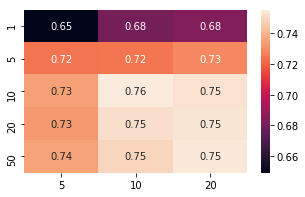

In [92]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

In [93]:
dep=10
n=20

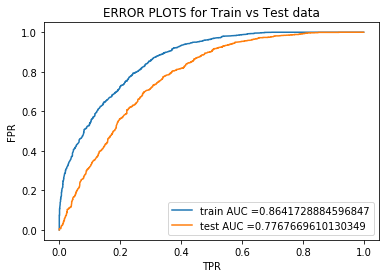

Train confusion matrix
[[1693  738]
 [ 324 2006]]
Test confusion matrix
[[ 948  553]
 [ 288 1127]]


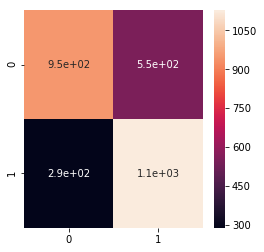

In [94]:
cf_rf,auc_rf=test_RandomForest(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)

In [95]:
#Precision
pr_rf=(cf_rf[0,0]/(cf_rf[0,1]+cf_rf[0,0]))
print(pr_rf*100)

63.1578947368421


In [96]:
X=data3[['gender', 'attr_o', 'sinc_o', 'intel_o', 'shar_o', 'prob_o', 'race', 'imprace', 'goal', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr', 'sinc', 'fun', 'amb', 'shar', 'prob']]
y=data3['dec']
X,y=adasamp(X,y)
X_1, X_test_ldfi, y_1, y_test_ldfi = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_ldfi, X_cv_ldfi, y_train_ldfi, y_cv_ldfi = train_test_split(X_1, y_1, test_size=0.3)

Distribution of datapoints in the given dataset:  {0: 3126, 1: 2435}
Distribution of datapoints after ADASYN Resampling:  {0: 3126, 1: 2718}


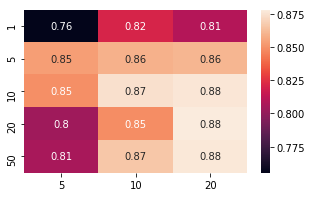

In [97]:
tr_auc_dec, cv_auc_dec=RF(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

cv_auc_dec=np.asarray(cv_auc_dec)
cv_auc_dec=cv_auc_dec.reshape(5,3)
heatmap_plot(tr_auc_dec, cv_auc_dec)

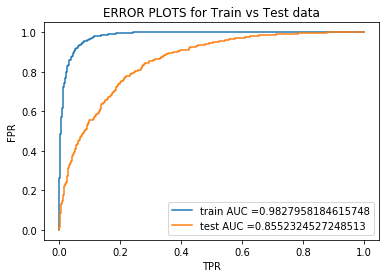

Train confusion matrix
[[1436  123]
 [  64 1240]]
Test confusion matrix
[[746 181]
 [218 609]]


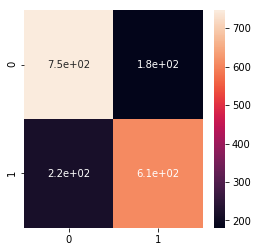

In [98]:
dep=10
n=20

cf_rf_dec,auc_rf_dec=test_RandomForest(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)

In [99]:
pr_rf_dec=(cf_rf_dec[0,0]/(cf_rf_dec[0,1]+cf_rf_dec[0,0]))
print(pr_rf_dec*100)

80.47464940668824


## XGBoost

In [100]:
def xgb_train(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    depth_values=[1,5,10,20,100]
    count=1
    for dep in depth_values:        
        estim=[5, 50, 100]
        for n in estim:
            xgb_clf=xgb.XGBClassifier(max_depth=dep,n_estimators=n)
            xgb_clf.fit(X_train,y_train)
            #y_coef=rf_clf.feature_importances_
            #print(f'{count}. depth={dep},estim={n} running...')
            y_pred=xgb_clf.predict(X_test)
            trauc=xgb_clf.predict_proba(X_train)[:,1]
            cvauc=xgb_clf.predict_proba(X_test)[:,1]
            
            
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count +=1
    #print(cv_auc)
    return  tr_auc,cv_auc

In [101]:
def test_xgb(X_train,y_train,X_test,y_test,dep,n):
    rf_clf=xgb.XGBClassifier(max_depth=dep,n_estimators=n)
    rf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
    
    test_auc=auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)
    return conf_mat,test_auc

In [102]:
tr_auc, cv_auc=xgb_train(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

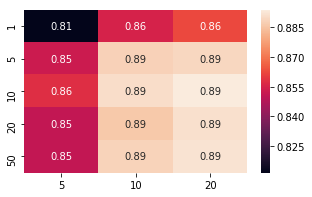

In [103]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

In [104]:
n=10
dep=10

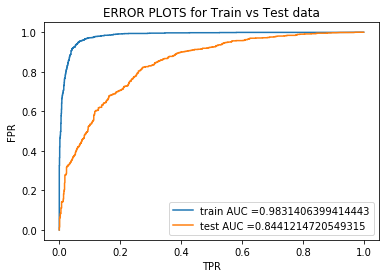

Train confusion matrix
[[1476   83]
 [  88 1216]]
Test confusion matrix
[[776 151]
 [270 557]]


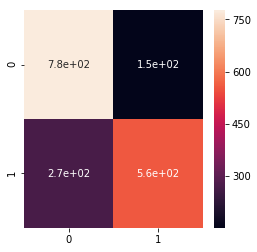

In [105]:
cf_xgb,auc_xgb=test_xgb(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)

In [106]:
#Precision
pr_xgb=(cf_xgb[0,0]/(cf_xgb[0,1]+cf_xgb[0,0]))
print(pr_xgb*100)

83.71089536138079


## SVC

In [119]:
def svc_train(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    count=1
    for g in range(-2,2):
        gam=math.pow(10,g)
        for i in range(-2,2):            
            c=math.pow(10,i)
            print(f'{count}. c={c},g={gam} running...')
            rbf_clf=SVC(C=c, kernel='rbf', gamma=gam,probability=True,class_weight='balanced')
            rbf_clf.fit(X_train,y_train)
            #rbf_clf.probability=True
            y_rbf=rbf_clf.predict(X_test)
            #y_coef=rbf_clf.dual_coef_
            trauc=rbf_clf.predict_proba(X_train)[:,1]
            cvauc=rbf_clf.predict_proba(X_test)[:,1]
            #print(roc_auc_score(y_train,trauc))
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count+=1
    #print(count)
    #print(len(tr_auc),len(cv_auc))
    return tr_auc,cv_auc

In [115]:
def plot_svc_train(title_plot,train_auc,cv_auc):
    al=range(0,16)
    plt.plot(al, train_auc, label='Train AUC')
    plt.plot(al, cv_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("Alpha")
    plt.ylabel("AUC")
    plt.title(title_plot)
    plt.show()

In [116]:
def plot_heatmap1(auc_tr,auc_cv):
    cm_pred=auc_cv
    cm = pd.DataFrame(auc_cv, index = [i for i in range(-2,2)],
                  columns = [i for i in range(-2,2)])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)

In [117]:
def test_rbf(X_train,y_train,X_test,y_test,c,gam):
    alph=math.pow(10,c)
    rbf_clf=SVC(C=c, kernel='rbf',gamma=gam,probability=True,class_weight='balanced')
    rbf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rbf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rbf_clf.predict_proba(X_test)[:,1])
    test_auc=auc(test_fpr, test_tpr)
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rbf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rbf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rbf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)
    return conf_mat,test_auc

In [118]:
tr_auc, cv_auc=svc_train(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

1. c=0.01,g=0.01 running...
2. c=0.1,g=0.01 running...
3. c=1.0,g=0.01 running...
4. c=10.0,g=0.01 running...
5. c=0.01,g=0.1 running...
6. c=0.1,g=0.1 running...
7. c=1.0,g=0.1 running...
8. c=10.0,g=0.1 running...
9. c=0.01,g=1.0 running...
10. c=0.1,g=1.0 running...
11. c=1.0,g=1.0 running...
12. c=10.0,g=1.0 running...
13. c=0.01,g=10.0 running...
14. c=0.1,g=10.0 running...
15. c=1.0,g=10.0 running...
16. c=10.0,g=10.0 running...
17
16 16


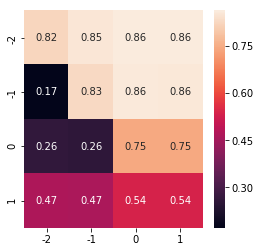

In [122]:
plot_name='ldfi'
cv_auc=np.asarray(cv_auc).reshape(16,1)
#print(bow_cv_auc)
#plot_svc_train(plot_name,tr_auc, cv_auc)
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(4,4)
#print(cv_auc.shape)
plot_heatmap1(tr_auc, cv_auc)

In [125]:
#alpha=11
c=1
gam=0.01

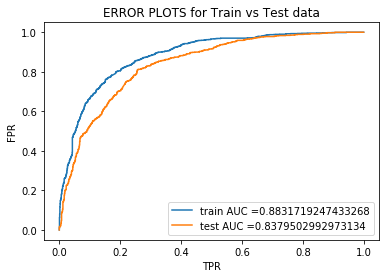

Train confusion matrix
[[1208  351]
 [ 220 1084]]
Test confusion matrix
[[695 232]
 [179 648]]


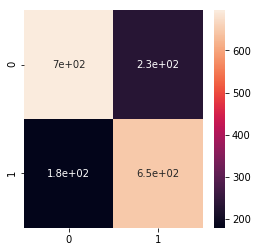

In [126]:
cf_svm,svm_auc=test_rbf(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,c,gam)

In [127]:
#Precision
pr=(cf_svm[0,0]/(cf_svm[0,1]+cf_svm[0,0]))
print(pr*100)

74.9730312837109


In [128]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","AUC","Precision"]

x.add_row(["RF" , auc_rf,pr_rf])
x.add_row(["XGB" ,auc_xgb,pr_xgb])
x.add_row(["SVC", svm_auc, pr])
print(x)

+-------+--------------------+-------------------+
| Model |        AUC         |     Precision     |
+-------+--------------------+-------------------+
|   RF  | 0.7767669610130349 | 0.631578947368421 |
|  XGB  | 0.8441214720549315 | 0.837108953613808 |
|  SVC  | 0.8379502992973134 | 0.749730312837109 |
+-------+--------------------+-------------------+


### Creating a new .csv

In [130]:
X_train=pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\X_train.csv')
y_train = pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\y_train.csv').values.ravel()
X_test = pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\X_test.csv')
y_test = pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\y_test.csv').values.ravel()

#X_train,y_train=adasamp(X_train,y_train)

In [131]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [132]:
tr_auc, cv_auc=RF(X_train,y_train,X_cv,y_cv)

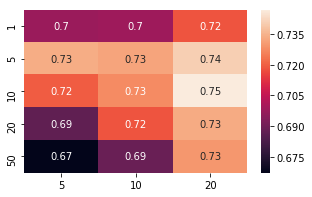

In [133]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

In [134]:
dep=5
n=20

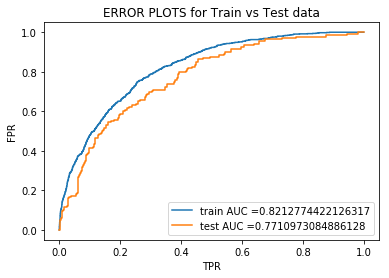

Train confusion matrix
[[3224 1193]
 [ 209  652]]
Test confusion matrix
[[513 187]
 [ 47  91]]


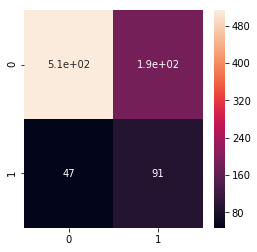

In [135]:
cf_rf_new,auc_rf_new=test_RandomForest(X_train,y_train,X_test,y_test,dep,n)

In [136]:
#Precision
pr_new=(cf_rf_new[0,0]/(cf_rf_new[0,1]+cf_rf_new[0,0]))
print(pr_new*100)

73.28571428571429


In [39]:
X_train=pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\X_train.csv')
y_train = pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\y_train.csv').values.ravel()
X_test = pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\X_test.csv')
y_test = pd.read_csv('SpeedDatingAnalysis-master\SpeedDatingAnalysis-master\data\y_test.csv').values.ravel()

#X_train,y_train=adasamp(X_train,y_train)



### SMOTE

In [137]:
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)
X_train,y_train=smote(X_train,y_train)

Distribution of datapoints in the given dataset:  {0: 4417, 1: 861}
Distribution of datapoints after SMOTE Resampling:  {0: 4417, 1: 4417}


In [138]:
tr_auc, cv_auc=RF(X_train,y_train,X_cv,y_cv)

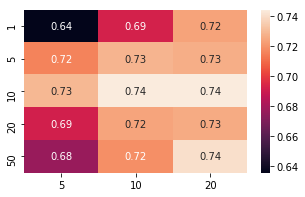

In [139]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

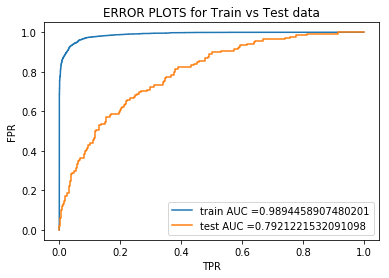

Train confusion matrix
[[4177  240]
 [ 235 4182]]
Test confusion matrix
[[634  66]
 [ 80  58]]


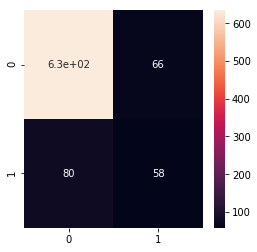

In [140]:
dep=10
n=20
cf_rf_new,auc_rf_new=test_RandomForest(X_train,y_train,X_test,y_test,dep,n)

In [142]:

#Precision
pr_new=(cf_rf_new[0,0]/(cf_rf_new[0,1]+cf_rf_new[0,0]))
print(pr_new*100)

90.57142857142857


In [60]:
X=data3[['iid','gender','age_o','int_corr','samerace','date','attr3_1','sinc3_1','fun3_1','intel3_1','amb3_1','attr','sinc','intel','fun','amb','shar','attr1_1','sinc1_1','intel1_1','fun1_1','amb1_1','shar1_1','pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha']]
y=data3['match']
X,y=adasamp(X,y)
X_1, X_test_ldfi, y_1, y_test_ldfi = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_ldfi, X_cv_ldfi, y_train_ldfi, y_cv_ldfi = train_test_split(X_1, y_1, test_size=0.3)

Distribution of datapoints in the given dataset:  {0: 4580, 1: 981}
Distribution of datapoints after ADASYN Resampling:  {0: 4580, 1: 4634}


In [64]:
tr_auc, cv_auc=xgb_train(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

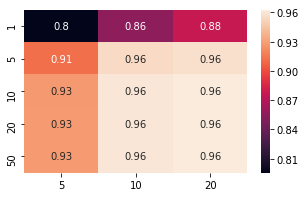

In [65]:

cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)


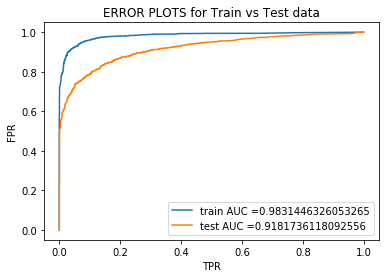

Train confusion matrix
[[2114  145]
 [ 136 2119]]
Test confusion matrix
[[1138  206]
 [ 225 1196]]


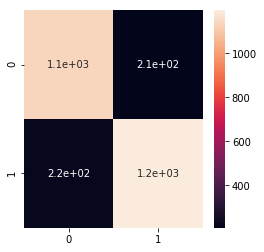

In [66]:
n=5
dep=10
cf_xgb,auc_xgb=test_xgb(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)


In [149]:
#Precision
pr_xgb_smote=(cf_xgb[0,0]/(cf_xgb[0,1]+cf_xgb[0,0]))
print(pr_xgb_smote*100)

91.44345238095238


In [144]:
X=data3[['iid','gender','age_o','int_corr','samerace','date','attr3_1','sinc3_1','fun3_1','intel3_1','amb3_1','attr','sinc','intel','fun','amb','shar','attr1_1','sinc1_1','intel1_1','fun1_1','amb1_1','shar1_1','pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha']]
y=data3['match']
X,y=adasamp(X,y)
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3)

Distribution of datapoints in the given dataset:  {0: 4580, 1: 981}
Distribution of datapoints after ADASYN Resampling:  {0: 4580, 1: 4634}


In [145]:
tr_auc, cv_auc=xgb_train(X_train,y_train,X_cv,y_cv)

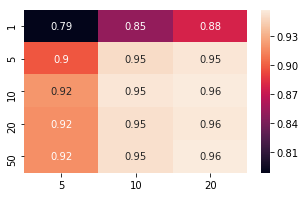

In [146]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

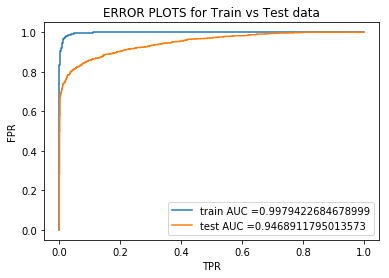

Train confusion matrix
[[2232   49]
 [  52 2181]]
Test confusion matrix
[[1229  115]
 [ 217 1204]]


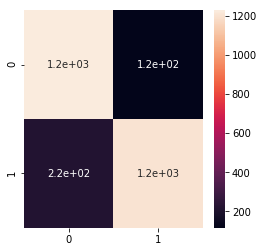

In [147]:
n=20
dep=10
cf_xgb,auc_xgb=test_xgb(X_train,y_train,X_test,y_test,dep,n)

In [150]:
#Precision
pr_xgb_new=(cf_rf_new[0,0]/(cf_rf_new[0,1]+cf_rf_new[0,0]))
print(pr_xgb_new*100)

90.57142857142857


### Recommendation

In [151]:
from scipy import spatial

In [153]:
d1=np.mean(data3[data3.iid==1])
d2=np.mean(data3[data3.iid==2])
cossim=spatial.distance.cosine(d1,d2)

In [154]:
cossim

0.13121248493586535

In [170]:
wave=data3.wave.unique()
wave

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21], dtype=int64)

In [227]:
wave1=data3[data3.wave==1]
wave2=data3[data3.wave==2]
wave3=data3[data3.wave==3]
wave4=data3[data3.wave==4]
wave5=data3[data3.wave==5]
wave6=data3[data3.wave==6]
wave7=data3[data3.wave==7]
wave8=data3[data3.wave==8]
wave9=data3[data3.wave==9]
wave10=data3[data3.wave==10]
wave11=data3[data3.wave==11]
wave12=data3[data3.wave==12]
wave13=data3[data3.wave==13]
wave14=data3[data3.wave==14]
wave15=data3[data3.wave==15]
wave16=data3[data3.wave==16]
wave17=data3[data3.wave==17]
wave18=data3[data3.wave==18]
wave19=data3[data3.wave==19]
wave20=data3[data3.wave==20]
wave21=data3[data3.wave==20]

In [228]:
wave1.head()

,iid,gender,wave,order,partner,pid,match,int_corr,samerace,age_o,...,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
0,1,0,1,4,1,11.0,0,0.14,0,27.0,...,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0
1,1,0,1,3,2,12.0,0,0.54,0,22.0,...,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0
3,1,0,1,5,4,14.0,1,0.61,0,23.0,...,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0,2.0
4,1,0,1,7,5,15.0,1,0.21,0,24.0,...,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0,2.0
5,1,0,1,6,6,16.0,0,0.25,0,25.0,...,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0,2.0


In [244]:
wave1.iid.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [302]:
sim=[]
flag=0
for i in wave1.iid.unique():
    for j in wave6.iid.unique():
        #print(i,j)
        #change the below 2 lines
        
        d1=np.mean(data3[data3.iid==i])
        d2=np.mean(data3[data3.iid==j])
        #print(d1)
        cos=spatial.distance.cosine(d1,d2)
        #print(cos)
        if cos>0.5:
            flag=1
            print('{} and {} are highly correlated with corr={}'.format(i,j,cos))
            sim.append(list([i,j]))
if flag==0:
    print('No correlation')

1 and 132 are highly correlated with corr=0.5161763265402651
1 and 133 are highly correlated with corr=0.5170327351537537
1 and 134 are highly correlated with corr=0.5217059420774406
1 and 137 are highly correlated with corr=0.5452125330080783
1 and 138 are highly correlated with corr=0.5470940810927667
1 and 140 are highly correlated with corr=0.5455571493384005
1 and 141 are highly correlated with corr=0.5501134065796562
2 and 132 are highly correlated with corr=0.5761284023948063
2 and 133 are highly correlated with corr=0.5776679896471981
2 and 134 are highly correlated with corr=0.591556865291274
2 and 137 are highly correlated with corr=0.6102071579433064
2 and 138 are highly correlated with corr=0.594288080473358
2 and 140 are highly correlated with corr=0.6005587373233481
2 and 141 are highly correlated with corr=0.5910552266971831
3 and 132 are highly correlated with corr=0.5452077709817725
3 and 133 are highly correlated with corr=0.5495213839971635
3 and 134 are highly corre

In [303]:
recomm=[]
for p in sim:
    #print(p)
    a1=data3[data3.iid==p[0]]
    a2=data3[data3.iid==p[1]]
    #print(a1)
    for i in range(a1.shape[0]):
        ab=a1.iloc[i]
        #print(ab)
        if ab.match==1:
            p2=ab['partner']
            recomm.append(list([p[0],p2]))
            print('{} recommended to {} based on match of {}'.format(int(p2),p[0],p[1]))
    for i in range(a2.shape[0]):
        ab=a2.iloc[i]
        #print(ab)
        if ab.match==1:
            p2=ab['partner']
            recomm.append(list([p[1],p2]))
            print('{} recommended to {} based on match of {}'.format(int(p2),p[1],p[0]))


4 recommended to 1 based on match of 132
5 recommended to 1 based on match of 132
9 recommended to 1 based on match of 132
6 recommended to 132 based on match of 1
4 recommended to 1 based on match of 133
5 recommended to 1 based on match of 133
9 recommended to 1 based on match of 133
4 recommended to 1 based on match of 134
5 recommended to 1 based on match of 134
9 recommended to 1 based on match of 134
1 recommended to 134 based on match of 1
4 recommended to 1 based on match of 137
5 recommended to 1 based on match of 137
9 recommended to 1 based on match of 137
3 recommended to 137 based on match of 1
4 recommended to 1 based on match of 138
5 recommended to 1 based on match of 138
9 recommended to 1 based on match of 138
4 recommended to 1 based on match of 140
5 recommended to 1 based on match of 140
9 recommended to 1 based on match of 140
1 recommended to 140 based on match of 1
4 recommended to 1 based on match of 141
5 recommended to 1 based on match of 141
9 recommended to

In [315]:
matches=wave1.match[wave1.match==1].count()+wave6.match[wave6.match==1].count()
print('Number of matches in both the waves:{}'.format(matches))
print('Number of additional recommendations:{}'.format(len(recomm)))

Number of matches in both the waves:60
Number of additional recommendations:237
